# Live Video Feed with Matplotlib

In [3]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

import sys
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from jetson.utils import cudaToNumpy, cudaMemcpy, cudaFromNumpy
from jetson_inference import poseNet
from jetson_utils import videoSource, cudaImage
import numpy as np
import os

In [2]:
cap = cv2.VideoCapture('/dev/video0')


(python3:22076): GStreamer-CRITICAL **: 02:37:33.151: 
Trying to dispose element pipeline0, but it is in READY instead of the NULL state.
You need to explicitly set elements to the NULL state before
dropping the final reference, to allow them to clean up.
This problem may also be caused by a refcounting bug in the
application or some element.

[ WARN:0] global /opt/opencv/modules/videoio/src/cap_gstreamer.cpp (888) open OpenCV | GStreamer warning: unable to start pipeline

(python3:22076): GStreamer-CRITICAL **: 02:37:33.151: 
Trying to dispose element videoconvert0, but it is in PAUSED instead of the NULL state.
You need to explicitly set elements to the NULL state before
dropping the final reference, to allow them to clean up.
This problem may also be caused by a refcounting bug in the
application or some element.

[ WARN:0] global /opt/opencv/modules/videoio/src/cap_gstreamer.cpp (480) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created

(python3

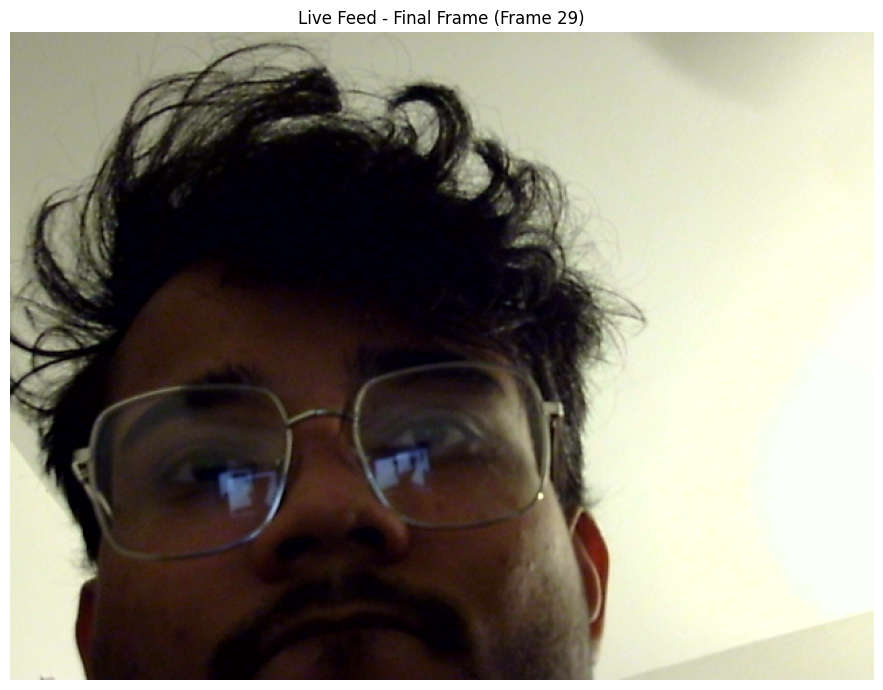


✓ Video feed stopped at frame 29
Last frame displayed above
Camera released successfully


In [ ]:
try:
    frame_count = 0
    last_frame_rgb = None  # store the last frame to display after interruption
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to read frame")
            break
        
        frame_count += 1
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        last_frame_rgb = frame_rgb 
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 7))
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.title(f'Live Feed - Frame {frame_count}')
        plt.show()
        
        # small delay to control frame rate
        time.sleep(0.033)  
        
except KeyboardInterrupt:
    print("\nVideo feed stopped by user")
finally:
    cap.release()
    
    if last_frame_rgb is not None:
        clear_output(wait=True)
        plt.figure(figsize=(10, 7))
        plt.imshow(last_frame_rgb)
        plt.axis('off')
        plt.title(f'Live Feed - Final Frame (Frame {frame_count})')
        plt.tight_layout()
        plt.show()
        print(f"\n✓ Video feed stopped at frame {frame_count}")
        print("Last frame displayed above")
    else:
        print("No frames were captured")
    
    plt.close('all')
    print("Camera released successfully")

# Let's bring in posenet model to extract bounding box from the face

In [4]:
net = poseNet("resnet18-body", threshold=0.15)
input_source = videoSource("/dev/video0")


poseNet -- loading pose estimation model from:
        -- model        networks/Pose-ResNet18-Body/pose_resnet18_body.onnx
        -- topology     networks/Pose-ResNet18-Body/human_pose.json
        -- colors       networks/Pose-ResNet18-Body/colors.txt
        -- input_blob   'input'
        -- output_cmap  'cmap'
        -- output_paf   'paf'
        -- threshold    0.150000
        -- batch_size   1

[TRT]    topology -- keypoint 0  nose
[TRT]    topology -- keypoint 1  left_eye
[TRT]    topology -- keypoint 2  right_eye
[TRT]    topology -- keypoint 3  left_ear
[TRT]    topology -- keypoint 4  right_ear
[TRT]    topology -- keypoint 5  left_shoulder
[TRT]    topology -- keypoint 6  right_shoulder
[TRT]    topology -- keypoint 7  left_elbow
[TRT]    topology -- keypoint 8  right_elbow
[TRT]    topology -- keypoint 9  left_wrist
[TRT]    topology -- keypoint 10  right_wrist
[TRT]    topology -- keypoint 11  left_hip
[TRT]    topology -- keypoint 12  right_hip
[TRT]    topology -- ke

In [5]:
mappings = {
    0: "Nose",
    1: "Left Eye",
    2: "Right Eye",
    3: "Left Ear",
    4: "Right Ear",
    5: "Left shoulder",
    6: "Right Shoulder",
    17: "neck"
}

# Colors
keypoint_color = (50, 205, 50)  
link_color = (255, 144, 30)     
head_bbox_color = (0, 191, 255)  
eye_bbox_color = (255, 0, 255)   
label_text_color = (255, 255, 255)

filtered_keypoints_ids = set(mappings.keys())

print("PoseNet model loaded successfully!")
print("Run the next cell to start live detection with bounding boxes")

PoseNet model loaded successfully!
Run the next cell to start live detection with bounding boxes


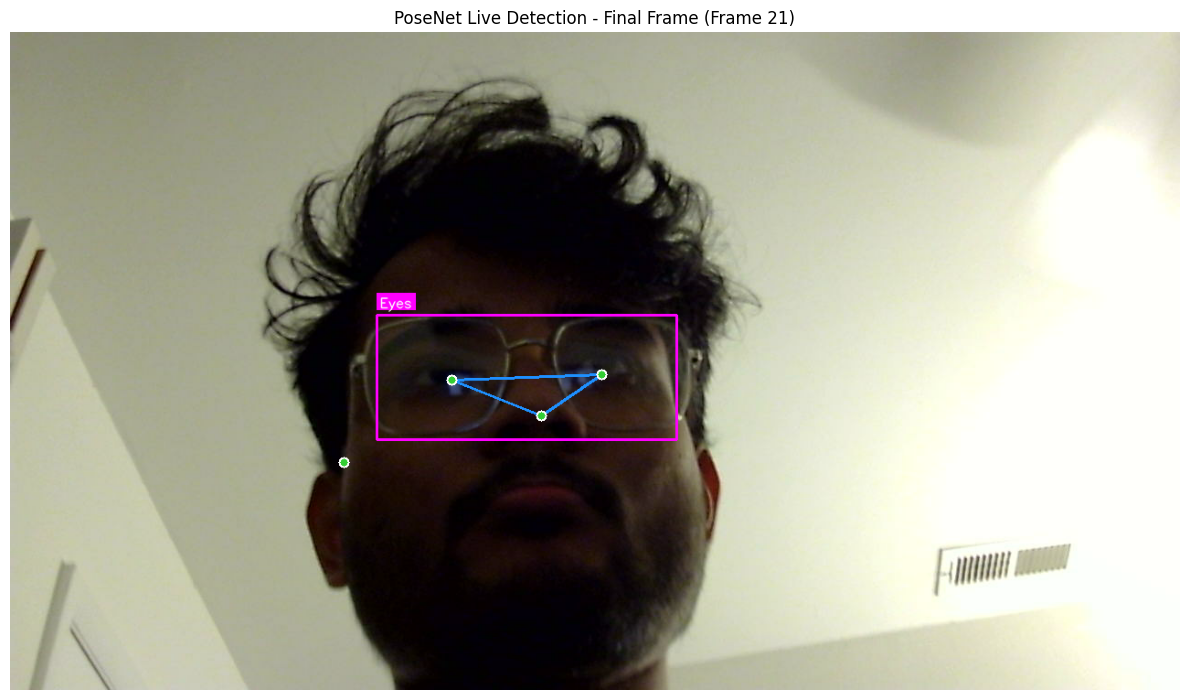


Detection stopped at frame 21
Last frame displayed above


In [ ]:
try:
    frame_count = 0
    font = cv2.FONT_HERSHEY_SIMPLEX
    last_frame_rgb = None  # store the last frame to display after interruption
    
    while True:
        img = input_source.Capture()
        
        if img is None:
            print("Failed to capture frame")
            continue
        
        # Copy to CPU for OpenCV processing
        raw_img = cudaImage(width=img.width, height=img.height, format=img.format)
        cudaMemcpy(raw_img, img)
        frame = cudaToNumpy(raw_img)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)
        
        poses = net.Process(img, overlay='none')
        
        for obj_idx, pose in enumerate(poses):
            keypoint_dict = {}
            
            for kp in pose.Keypoints:
                kp_id = int(kp.ID)
                if kp_id in filtered_keypoints_ids:
                    keypoint_dict[kp_id] = (int(kp.x), int(kp.y))
            
            # get key points for eyes
            left_eye = keypoint_dict.get(1)
            right_eye = keypoint_dict.get(2)
            
            # draw eye bounding box if both eyes are detected
            if left_eye is not None and right_eye is not None:
                eye_x_coords = [left_eye[0], right_eye[0]]
                eye_y_coords = [left_eye[1], right_eye[1]]
                
                eye_min_x = min(eye_x_coords)
                eye_max_x = max(eye_x_coords)
                eye_min_y = min(eye_y_coords)
                eye_max_y = max(eye_y_coords)
                
                # add padding around eyes
                eye_width = eye_max_x - eye_min_x
                eye_height = eye_max_y - eye_min_y
                
                # maakking the box wider and taller to cover both eyes comfortably inside the box
                eye_padding_x = int(eye_width * 0.5)
                eye_padding_y = int(max(eye_height * 2.0, eye_width * 0.4))  #just making sure it tall enough
                
                eye_bbox_x1 = max(0, eye_min_x - eye_padding_x)
                eye_bbox_y1 = max(0, eye_min_y - eye_padding_y)
                eye_bbox_x2 = min(frame.shape[1], eye_max_x + eye_padding_x)
                eye_bbox_y2 = min(frame.shape[0], eye_max_y + eye_padding_y)
                
                cv2.rectangle(frame, (eye_bbox_x1, eye_bbox_y1), (eye_bbox_x2, eye_bbox_y2), eye_bbox_color, 2)
                
                eye_label = "Eyes"
                eye_font_scale = 0.5
                (eye_text_w, eye_text_h), _ = cv2.getTextSize(eye_label, font, eye_font_scale, 1)
                
                eye_label_x = eye_bbox_x1
                eye_label_y = max(eye_bbox_y1 - 8, 15)
                
                cv2.rectangle(frame, (eye_label_x, eye_label_y - eye_text_h - 4), (eye_label_x + eye_text_w + 6, eye_label_y + 2), eye_bbox_color, -1)
                cv2.putText(frame, eye_label, (eye_label_x + 3, eye_label_y), font, eye_font_scale, label_text_color, 1, cv2.LINE_AA)
            
            # draw skeleton links
            try:
                for link in pose.Links:
                    if isinstance(link, tuple) and len(link) == 2:
                        start_id, end_id = link
                    else:
                        continue
                    
                    if start_id in keypoint_dict and end_id in keypoint_dict:
                        start_point = keypoint_dict[start_id]
                        end_point = keypoint_dict[end_id]
                        cv2.line(frame, start_point, end_point, link_color, 2)
            except:
                pass
            
            # draw keypoints
            for kp_id, (x, y) in keypoint_dict.items():
                cv2.circle(frame, (x, y), 6, (255, 255, 255), -1)
                cv2.circle(frame, (x, y), 4, keypoint_color, -1)
        
        frame_count += 1
        
        # Convert to RGB for matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        last_frame_rgb = frame_rgb  
        
        clear_output(wait=True)
        plt.figure(figsize=(12, 8))
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.title(f'PoseNet Live Detection - Frame {frame_count}')
        plt.tight_layout()
        plt.show()
        
except KeyboardInterrupt:
    print("\nPoseNet detection stopped by user")
finally:
    if last_frame_rgb is not None:
        clear_output(wait=True)
        plt.figure(figsize=(12, 8))
        plt.imshow(last_frame_rgb)
        plt.axis('off')
        plt.title(f'PoseNet Live Detection - Final Frame (Frame {frame_count})')
        plt.tight_layout()
        plt.show()
        print(f"\nDetection stopped at frame {frame_count}")
        print("Last frame displayed above")
    else:
        print("No frames were captured")
    
    plt.close('all')

# Extracting and Saving Eyes Bounding Boxes From Captured Images

In [6]:
def extract_and_save_eye_bbox(image_path, save_path):
    try:
        frame = cv2.imread(image_path)
        if frame is None:
            print(f"Failed to read image: {image_path}")
            return False
        
        frame_rgba = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
        cuda_img = cudaFromNumpy(frame_rgba)
        poses = net.Process(cuda_img, overlay='none')
        
        if len(poses) == 0:
            print(f"No person detected in: {image_path}")
            return False
        
        pose = poses[0]
        keypoint_dict = {}
        
        for kp in pose.Keypoints:
            kp_id = int(kp.ID)
            if kp_id in filtered_keypoints_ids:
                keypoint_dict[kp_id] = (int(kp.x), int(kp.y))
        
        left_eye = keypoint_dict.get(1)
        right_eye = keypoint_dict.get(2)
        
        if left_eye is None or right_eye is None:
            print(f"Eyes not detected in: {image_path}")
            return False
        
        eye_x_coords = [left_eye[0], right_eye[0]]
        eye_y_coords = [left_eye[1], right_eye[1]]
        
        eye_min_x = min(eye_x_coords)
        eye_max_x = max(eye_x_coords)
        eye_min_y = min(eye_y_coords)
        eye_max_y = max(eye_y_coords)
        
        eye_width = eye_max_x - eye_min_x
        eye_height = eye_max_y - eye_min_y        
        eye_padding_x = int(eye_width * 0.5)
        eye_padding_y = int(max(eye_height * 2.0, eye_width * 0.4))
        
        eye_bbox_x1 = max(0, eye_min_x - eye_padding_x)
        eye_bbox_y1 = max(0, eye_min_y - eye_padding_y)
        eye_bbox_x2 = min(frame.shape[1], eye_max_x + eye_padding_x)
        eye_bbox_y2 = min(frame.shape[0], eye_max_y + eye_padding_y)
        
        eye_crop = frame[eye_bbox_y1:eye_bbox_y2, eye_bbox_x1:eye_bbox_x2]
        
        if eye_crop.size == 0:
            print(f"Invalid crop dimensions for: {image_path}")
            return False
        
        os.makedirs(save_path, exist_ok=True)
        
        filename = os.path.basename(image_path)
        output_file = os.path.join(save_path, filename)
        
        cv2.imwrite(output_file, eye_crop)
        return True
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return False

In [7]:
test_file_path = r'/jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443225391_1.png'
save_directory = r'/jetson-inference/jetson-nano/FINAL_TRAINING_DATA/DROWSY'

In [8]:
extract_and_save_eye_bbox(test_file_path, save_directory)

True

In [11]:
import matplotlib.image as mpimg

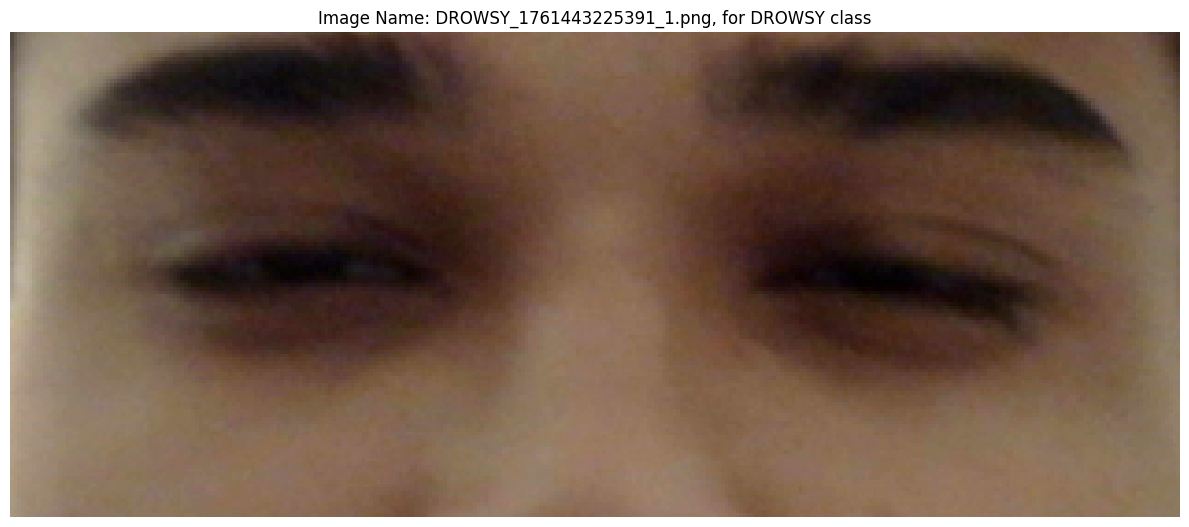

In [14]:
new_file_path = os.path.join(save_directory, os.path.basename(test_file_path))
img = mpimg.imread(new_file_path)

plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title(f'Image Name: {os.path.basename(test_file_path)}, for DROWSY class')
plt.tight_layout()
plt.show()

So, this is the extracted drowsy eyes frame. Let's look at non drowsy frame next.

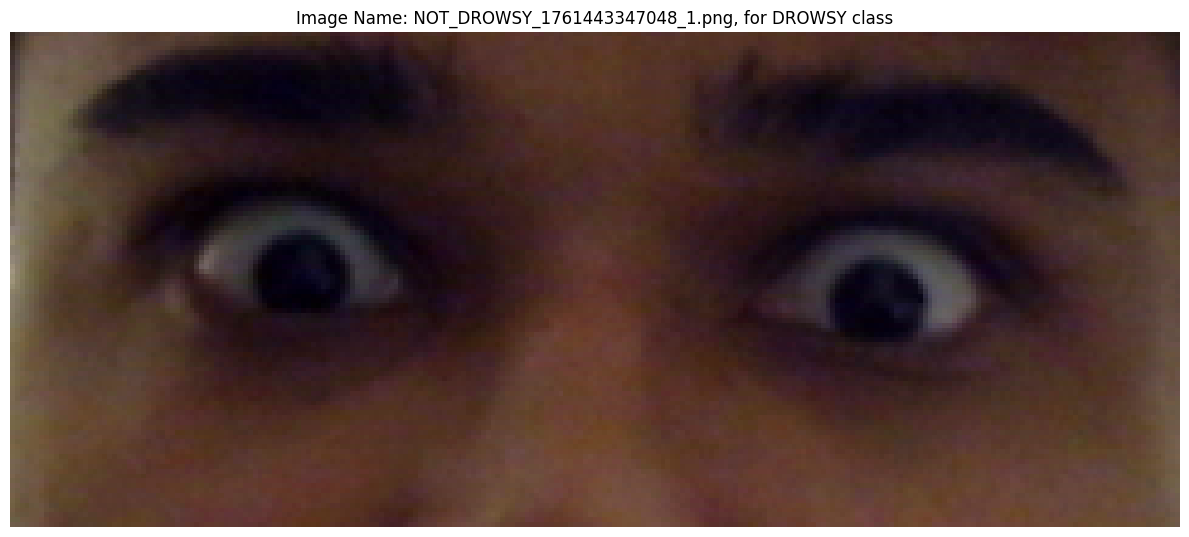

In [15]:
test_file_path = r'/jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443347048_1.png'
save_directory = r'/jetson-inference/jetson-nano/FINAL_TRAINING_DATA/NOT_DROWSY'

if extract_and_save_eye_bbox(test_file_path, save_directory):
    new_file_path = os.path.join(save_directory, os.path.basename(test_file_path))
    img = mpimg.imread(new_file_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image Name: {os.path.basename(test_file_path)}, for DROWSY class')
    plt.tight_layout()
    plt.show()

<b> Perfect. Let's run loop and process all the images for training

# Processing pre-captured images with loop

In [16]:
drowsy_folder_path = r'/jetson-inference/jetson-nano/TRAINING_DATA/DROWSY'
files = [os.path.join(drowsy_folder_path, f) for f in os.listdir(drowsy_folder_path)]
len(files)

1000

In [17]:
from tqdm import tqdm

In [18]:
for file in tqdm(files):
    extract_and_save_eye_bbox(file, r'/jetson-inference/jetson-nano/FINAL_TRAINING_DATA/DROWSY')

  2%|▏         | 17/1000 [00:00<00:24, 39.44it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443285859_920.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443287680_949.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443287489_946.png


  4%|▎         | 36/1000 [00:00<00:23, 40.37it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443288317_959.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443286985_938.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443290678_996.png


  6%|▌         | 56/1000 [00:01<00:23, 40.24it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443285670_917.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443280583_837.png


  9%|▊         | 86/1000 [00:02<00:22, 40.93it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443289078_971.png


 11%|█         | 111/1000 [00:02<00:21, 41.40it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443276439_772.png


 13%|█▎        | 131/1000 [00:03<00:21, 41.18it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443287870_952.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443286300_927.png


 14%|█▍        | 141/1000 [00:03<00:20, 41.13it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443276503_773.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443281083_845.png


 16%|█▌        | 156/1000 [00:03<00:20, 40.65it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443286237_926.png


 17%|█▋        | 171/1000 [00:04<00:20, 41.01it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443287298_943.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443286110_924.png


 19%|█▊        | 186/1000 [00:04<00:19, 41.27it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443285224_910.png


 21%|██        | 206/1000 [00:05<00:19, 41.73it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443285099_908.png
Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443275989_765.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443287109_940.png


 22%|██▏       | 221/1000 [00:05<00:18, 41.70it/s]

Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443282627_869.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443288953_969.png


 23%|██▎       | 231/1000 [00:05<00:18, 42.25it/s]

Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443279499_820.png
Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443288574_963.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443280519_836.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443288827_967.png


 25%|██▍       | 246/1000 [00:06<00:18, 41.46it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443286614_932.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443286861_936.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443286737_934.png


 26%|██▌       | 261/1000 [00:06<00:17, 41.26it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443280833_841.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443285796_919.png


 27%|██▋       | 271/1000 [00:06<00:17, 41.02it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443287362_944.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443285921_921.png


 29%|██▉       | 291/1000 [00:07<00:17, 41.06it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443280709_839.png


 30%|███       | 301/1000 [00:07<00:17, 40.94it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443287616_948.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443284719_902.png


 31%|███       | 311/1000 [00:07<00:16, 40.90it/s]

Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443282562_868.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443276184_768.png


 34%|███▎      | 336/1000 [00:08<00:15, 41.59it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443285607_916.png


 35%|███▌      | 351/1000 [00:08<00:15, 41.05it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443280896_842.png


 38%|███▊      | 376/1000 [00:09<00:15, 40.78it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443287235_942.png


 39%|███▉      | 391/1000 [00:09<00:14, 41.18it/s]

Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443276567_774.png


 42%|████▏     | 416/1000 [00:10<00:14, 41.02it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443288764_966.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443286364_928.png


 43%|████▎     | 426/1000 [00:10<00:14, 40.58it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443284973_906.png


 44%|████▎     | 436/1000 [00:10<00:13, 40.80it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443289395_976.png


 45%|████▍     | 446/1000 [00:10<00:13, 40.95it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443287426_945.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443277014_781.png


 47%|████▋     | 466/1000 [00:11<00:13, 40.34it/s]

Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443290486_993.png


 48%|████▊     | 481/1000 [00:11<00:13, 39.86it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443286675_933.png


 50%|█████     | 500/1000 [00:12<00:12, 40.71it/s]

[TRT]    poseNet::postProcess() -- duplicate link detected, skipping...
Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443290166_988.png


 52%|█████▎    | 525/1000 [00:12<00:11, 41.12it/s]

Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443289015_970.png


 56%|█████▌    | 555/1000 [00:13<00:10, 40.88it/s]

Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443284528_899.png


 56%|█████▋    | 565/1000 [00:13<00:10, 40.81it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443290550_994.png


 58%|█████▊    | 580/1000 [00:14<00:10, 40.73it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443280455_835.png


 60%|█████▉    | 595/1000 [00:14<00:09, 41.28it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443285162_909.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443281146_846.png
Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443276247_769.png


 62%|██████▏   | 615/1000 [00:15<00:09, 40.98it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443284656_901.png


 63%|██████▎   | 630/1000 [00:15<00:09, 40.78it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443290615_995.png


 64%|██████▍   | 640/1000 [00:15<00:08, 41.03it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443280771_840.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443288701_965.png


 66%|██████▋   | 665/1000 [00:16<00:08, 41.66it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443284782_903.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443284591_900.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443285733_918.png


 68%|██████▊   | 675/1000 [00:16<00:07, 41.32it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443287807_951.png


 69%|██████▉   | 690/1000 [00:16<00:07, 40.35it/s]

Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443282436_866.png


 70%|███████   | 700/1000 [00:17<00:07, 40.45it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443280646_838.png


 71%|███████   | 710/1000 [00:17<00:07, 40.64it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443281020_844.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443286552_931.png


 72%|███████▏  | 720/1000 [00:17<00:06, 40.93it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443287744_950.png


 74%|███████▎  | 735/1000 [00:17<00:06, 40.66it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443288637_964.png


 74%|███████▍  | 745/1000 [00:18<00:06, 40.68it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443289140_972.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443285412_913.png


 76%|███████▌  | 755/1000 [00:18<00:06, 40.83it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443287996_954.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443289331_975.png


 78%|███████▊  | 775/1000 [00:18<00:05, 41.06it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443276055_766.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443285287_911.png


 78%|███████▊  | 785/1000 [00:19<00:05, 40.99it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443276631_775.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443286923_937.png


 80%|████████  | 800/1000 [00:19<00:04, 41.34it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443288891_968.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443285476_914.png
Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443276375_771.png


 81%|████████  | 810/1000 [00:19<00:04, 41.13it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443285543_915.png


 82%|████████▏ | 820/1000 [00:20<00:04, 40.86it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443287932_953.png


 83%|████████▎ | 830/1000 [00:20<00:04, 40.54it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443286427_929.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443286490_930.png


 84%|████████▍ | 844/1000 [00:20<00:03, 39.88it/s]

[TRT]    poseNet::postProcess() -- duplicate link detected, skipping...
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443276311_770.png


 88%|████████▊ | 878/1000 [00:21<00:03, 37.31it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443287172_941.png


 90%|█████████ | 903/1000 [00:22<00:02, 41.42it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443286174_925.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443285983_922.png


 92%|█████████▏| 918/1000 [00:22<00:01, 42.52it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443284846_904.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443286047_923.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443287047_939.png
Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443284464_898.png


 94%|█████████▍| 943/1000 [00:23<00:01, 40.65it/s]

Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443282499_867.png


 96%|█████████▌| 958/1000 [00:23<00:01, 41.29it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443286799_935.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443290866_999.png


 97%|█████████▋| 973/1000 [00:23<00:00, 40.91it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443285035_907.png


 99%|█████████▉| 993/1000 [00:24<00:00, 41.16it/s]

Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443275924_764.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443284910_905.png


100%|██████████| 1000/1000 [00:24<00:00, 40.81it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443280958_843.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/DROWSY/DROWSY_1761443285349_912.png


In [19]:
len(os.listdir(r'/jetson-inference/jetson-nano/FINAL_TRAINING_DATA/DROWSY'))

896

Our posenet model couldn't detect eyes in some of the pre-captured frames. That is understandable as we set the classification threshold pretty high for our model. Lets process for NOT DROWSY case.

In [22]:
notdrowsy_folder_path = r'/jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY'
files = [os.path.join(notdrowsy_folder_path, f) for f in os.listdir(notdrowsy_folder_path)]
len(files)

1000

In [23]:
for file in tqdm(files):
    extract_and_save_eye_bbox(file, r'/jetson-inference/jetson-nano/FINAL_TRAINING_DATA/NOT_DROWSY')

  1%|          | 9/1000 [00:00<00:24, 41.18it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443368670_332.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443372490_392.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443371983_384.png


  3%|▎         | 29/1000 [00:00<00:24, 40.01it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443372868_398.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443405414_895.png


  6%|▌         | 58/1000 [00:01<00:23, 39.98it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443368799_334.png
Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443369433_344.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443371085_370.png


  9%|▉         | 90/1000 [00:02<00:22, 40.13it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443370577_362.png


 13%|█▎        | 127/1000 [00:03<00:21, 40.71it/s]

Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443405480_896.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443373248_404.png
Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443367901_320.png


 15%|█▍        | 147/1000 [00:03<00:20, 41.18it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443372047_385.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443372236_388.png


 18%|█▊        | 182/1000 [00:04<00:20, 40.37it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443367710_317.png
Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443375561_440.png


 20%|█▉        | 197/1000 [00:04<00:19, 40.36it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443373121_402.png


 24%|██▍       | 239/1000 [00:05<00:18, 40.85it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443373185_403.png


 32%|███▏      | 322/1000 [00:08<00:16, 40.13it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443372616_394.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443372993_400.png


 34%|███▎      | 335/1000 [00:08<00:16, 39.59it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443372680_395.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443370706_364.png


 36%|███▌      | 359/1000 [00:08<00:15, 40.46it/s]

Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443368607_331.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443369623_347.png


 38%|███▊      | 379/1000 [00:09<00:15, 40.93it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443370959_368.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443372363_390.png


 43%|████▎     | 429/1000 [00:10<00:14, 40.64it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443372299_389.png


 45%|████▍     | 449/1000 [00:11<00:13, 39.45it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443372806_397.png


 48%|████▊     | 479/1000 [00:11<00:12, 40.24it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443405335_894.png


 49%|████▉     | 488/1000 [00:12<00:12, 39.92it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443405750_900.png


 50%|█████     | 505/1000 [00:12<00:12, 39.63it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443369944_352.png


 52%|█████▏    | 524/1000 [00:13<00:11, 40.73it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443368734_333.png


 54%|█████▍    | 538/1000 [00:13<00:11, 40.31it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443372428_391.png


 56%|█████▌    | 556/1000 [00:13<00:11, 39.26it/s]

Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443375304_436.png
Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443375369_437.png
Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443405814_901.png


 57%|█████▋    | 570/1000 [00:14<00:10, 39.88it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443367837_319.png


 59%|█████▉    | 592/1000 [00:14<00:10, 40.49it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443369816_350.png
Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443370514_361.png


 60%|██████    | 602/1000 [00:15<00:10, 39.68it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443369496_345.png


 62%|██████▏   | 624/1000 [00:15<00:09, 39.89it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443370833_366.png


 65%|██████▌   | 651/1000 [00:16<00:08, 40.96it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443369752_349.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443372108_386.png
Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443370195_356.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443405547_897.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443369879_351.png


 66%|██████▌   | 661/1000 [00:16<00:08, 40.66it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443369687_348.png


 68%|██████▊   | 681/1000 [00:17<00:07, 40.43it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443405613_898.png


 71%|███████   | 706/1000 [00:17<00:07, 40.26it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443371793_381.png


 74%|███████▎  | 735/1000 [00:18<00:06, 40.44it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443368480_329.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443371856_382.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443371022_369.png


 75%|███████▌  | 750/1000 [00:18<00:06, 39.62it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443370006_353.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443373056_401.png


 76%|███████▋  | 765/1000 [00:19<00:05, 40.07it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443372931_399.png


 78%|███████▊  | 782/1000 [00:19<00:05, 37.92it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443405678_899.png


 84%|████████▍ | 842/1000 [00:21<00:03, 40.70it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443370896_367.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443372553_393.png


 88%|████████▊ | 877/1000 [00:21<00:03, 40.68it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443371920_383.png


 90%|████████▉ | 897/1000 [00:22<00:02, 40.15it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443369558_346.png


 91%|█████████ | 906/1000 [00:22<00:02, 39.59it/s]

Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443405880_902.png


 92%|█████████▏| 923/1000 [00:23<00:01, 39.92it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443367773_318.png
Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443375497_439.png
Eyes not detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443375433_438.png


 95%|█████████▌| 951/1000 [00:23<00:01, 39.93it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443370641_363.png
No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443370769_365.png


 97%|█████████▋| 966/1000 [00:24<00:00, 40.26it/s]

No person detected in: /jetson-inference/jetson-nano/TRAINING_DATA/NOT_DROWSY/NOT_DROWSY_1761443372171_387.png


 99%|█████████▊| 986/1000 [00:24<00:00, 40.04it/s]

[TRT]    poseNet::postProcess() -- duplicate link detected, skipping...


100%|██████████| 1000/1000 [00:25<00:00, 39.99it/s]


In [24]:
len(os.listdir(r'/jetson-inference/jetson-nano/FINAL_TRAINING_DATA/NOT_DROWSY'))

933

<b> Perfect!!! Our training data is complete. Lets train a pretrained MobileNet_v2-mini model trained on imagenet dataset, replace it's classification head with our custom binaru classification head and train the model and integrate it in our final pipeline.